# Importing the libraries

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import pickle
import numpy as np
import os

In [3]:

from google.colab import files
uploaded = files.upload()

Saving ip for rnn.txt to ip for rnn.txt


# Loading and Pre-Processing the Data

In [4]:
# Now, Let's Load the data.
file = open("ip for rnn.txt", "r", encoding = "utf8")
# we opened the file in reading mode.

#Let's Pre-Process the data.
#Pre-Processng methods depends on our data.

# store file in list
lines = []
for i in file:
    lines.append(i)

# Convert list to string
data = ""
for i in lines:
  data = ' '. join(lines)

#Depending on our data these steps are needed to mae our data suitable for processing.
#replace unnecessary stuff with space
data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '').replace('“','').replace('”','')  #new line, carriage return, unicode character --> replace by space

#remove unnecessary spaces 
data = data.split()
data = ' '.join(data)
data[:500]

'The Project Gutenberg eBook of Pride and Prejudice, by Jane Austen This eBook is for the use of anyone anywhere in the United States and most other parts of the world at no cost and with almost no restrictions whatsoever. You may copy it, give it away or re-use it under the terms of the Project Gutenberg License included with this eBook or online at www.gutenberg.org. If you are not located in the United States, you will have to check the laws of the country where you are located before using th'

In [5]:
len(data)


698483

# Tokenizer:

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])

# saving the tokenizer for predict function
pickle.dump(tokenizer, open('token.pkl', 'wb'))

sequence_data = tokenizer.texts_to_sequences([data])[0]
sequence_data[:15]

[1, 176, 157, 916, 3, 321, 4, 1174, 30, 72, 2535, 41, 916, 23, 21]

In [7]:
len(sequence_data)


125317

In [8]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

7036


Here we are using 3 words to predict the 4th word.

In [9]:
sequences = []

for i in range(3, len(sequence_data)):
    words = sequence_data[i-3:i+1]
    sequences.append(words)
    
print("The Length of sequences are: ", len(sequences))
sequences = np.array(sequences)
sequences[:10]

The Length of sequences are:  125314


array([[   1,  176,  157,  916],
       [ 176,  157,  916,    3],
       [ 157,  916,    3,  321],
       [ 916,    3,  321,    4],
       [   3,  321,    4, 1174],
       [ 321,    4, 1174,   30],
       [   4, 1174,   30,   72],
       [1174,   30,   72, 2535],
       [  30,   72, 2535,   41],
       [  72, 2535,   41,  916]])

Above array each element has 4 elements the first 3 are the input and the last word is the output.

In [10]:
# Now as we got to kow what are the i/p and o/p are so let's separate them.
X = []
y = []

for i in sequences:
    X.append(i[0:3])
    y.append(i[3])
    
X = np.array(X)
y = np.array(y)

In [11]:
print("Input Data: ", X[:10])
print("Output Response: ", y[:10])


Input Data:  [[   1  176  157]
 [ 176  157  916]
 [ 157  916    3]
 [ 916    3  321]
 [   3  321    4]
 [ 321    4 1174]
 [   4 1174   30]
 [1174   30   72]
 [  30   72 2535]
 [  72 2535   41]]
Output Response:  [ 916    3  321    4 1174   30   72 2535   41  916]


In [12]:
#Now we will be converting our Class Vectors into some binary Class Matrix Later we will be using Loss function as Categorical Loss entropy. This requires our Interger values to be in Binary Matrice.
y = to_categorical(y, num_classes=vocab_size)
y[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Now Let's Create the Model

In [13]:
#we will be using Sequential for our model RNN
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=3))
#input_length means we will be using 3 words to predict next word.
model.add(LSTM(1000, return_sequences=True))
model.add(LSTM(1000))
#Two LSTM layers are there
model.add(Dense(1000, activation="relu"))
model.add(Dense(vocab_size, activation="softmax"))

In [14]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 3, 10)             70360     
_________________________________________________________________
lstm (LSTM)                  (None, 3, 1000)           4044000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 1000)              8004000   
_________________________________________________________________
dense (Dense)                (None, 1000)              1001000   
_________________________________________________________________
dense_1 (Dense)              (None, 7036)              7043036   
Total params: 20,162,396
Trainable params: 20,162,396
Non-trainable params: 0
_________________________________________________________________


# Ploting Our Model

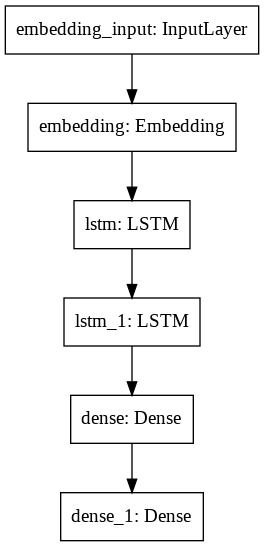

In [15]:
#Just Take a look at Our Model

from tensorflow import keras
from keras.utils.vis_utils import plot_model

keras.utils.plot_model(model, to_file='plot.png', show_layer_names=True)

# Building Our Model

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("next_words.h5", monitor='loss', verbose=1, save_best_only=True)
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001))
model.fit(X, y, epochs=70, batch_size=64, callbacks=[checkpoint])

Epoch 1/70
1959/1959 [==============================] - 38s 15ms/step - loss: 6.2294

Epoch 00001: loss improved from inf to 6.22942, saving model to next_words.h5
Epoch 2/70
1959/1959 [==============================] - 30s 15ms/step - loss: 5.5943

Epoch 00002: loss improved from 6.22942 to 5.59425, saving model to next_words.h5
Epoch 3/70
1959/1959 [==============================] - 30s 15ms/step - loss: 5.2643

Epoch 00003: loss improved from 5.59425 to 5.26425, saving model to next_words.h5
Epoch 4/70
1959/1959 [==============================] - 30s 15ms/step - loss: 5.0368

Epoch 00004: loss improved from 5.26425 to 5.03678, saving model to next_words.h5
Epoch 5/70
1959/1959 [==============================] - 30s 15ms/step - loss: 4.8360

Epoch 00005: loss improved from 5.03678 to 4.83603, saving model to next_words.h5
Epoch 6/70
1959/1959 [==============================] - 30s 15ms/step - loss: 4.6383

Epoch 00006: loss improved from 4.83603 to 4.63827, saving model to next_words

# Prediction:

In [17]:
from tensorflow.keras.models import load_model
import numpy as np
import pickle

# Load the model and tokenizer
model = load_model('next_words.h5')
tokenizer = pickle.load(open('token.pkl', 'rb'))

def Predict_Next_Words(model, tokenizer, text):

  sequence = tokenizer.texts_to_sequences([text])
  sequence = np.array(sequence)
  preds = np.argmax(model.predict(sequence))
  predicted_word = ""
  
  for key, value in tokenizer.word_index.items():
      if value == preds:
          predicted_word = key
          break
  
  print(predicted_word)
  return predicted_word

In [18]:
while(True):
  text = input("Enter your line: ")
  
  if text == "0":
      print("Execution completed.....")
      break
  
  else:
      try:
          text = text.split(" ")
          text = text[-3:]
          print(text)
        
          Predict_Next_Words(model, tokenizer, text)
          
      except Exception as e:
        print("Error occurred: ",e)
        continue

Enter your line: after the melancholy scene so lately
['scene', 'so', 'lately']
gone
Enter your line: 0
Execution completed.....
